# Differentiable physics demo

In this demo we will solve the Brachistochrone problem using differentiable physics.

This demo is inspired by https://scipython.com/blog/the-brachistochrone-problem/ and https://www.youtube.com/watch?v=skvnj67YGmw

Written by Ben Moseley

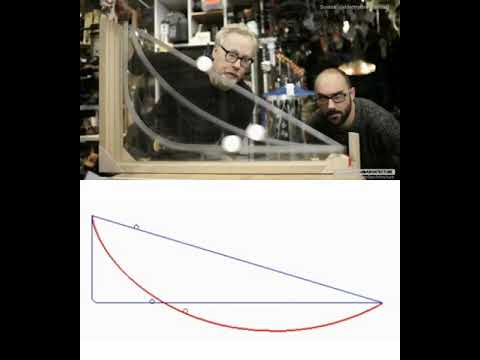

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('H-qNPV4WSsE', width=800, height=300, 
             allow_autoplay=True, controls=0, loop=1, playlist="H-qNPV4WSsE,")

## Problem overview

The Brachistochrone problem is:

> What is the shape of the **curve** down which a ball, starting from rest and accelerated by gravity, will roll, without friction, from one fixed point, P1 to another P2 in the **least** amount time?"

Let the curve be described as $y=f(x)$, where $f$ is the function we wish to find.

Also let (without loss of generality), $P1=(0,0)$ and $P2=(x_2,y_2)$.

## Approach

To solve this problem we will **aproximate** $f(x)$ with a neural network, i.e. $f(x)\approx N\!N(x; \theta)$.

We will **train** the network (learn $f$) by using a loss function which **minimises** the total travel time of the ball.


## Physics model

To define our loss function, we need to **derive** an expression for the total travel time of the ball given $f$.

Let $s$ be the distance the ball has travelled **along** the curve. Then the **total travel time** of the ball is given by

$$
T = \int_{s=0}^{s=L} \frac{1}{v} ds ~~~~~~~~~(1)
$$

where $v$ is the velocity of the ball along the curve.

Note that, wherever the ball is on the curve, it must obey **conservation of energy**, i.e.

$$
\frac{1}{2}m v^2 = m g y
$$

where $m$ is the mass of the ball, $v$ is its velocity, $g=9.81$ is the acceleration due to gravity and $y$ is the height of the ball.

Rearranging for $v$ gives

$$
v = \sqrt{2 g y}
$$

Plugging this into $(1)$ gives

$$
T = \int_{s=0}^{s=L} \frac{1}{\sqrt{2 g y}} ds
$$

where $L$ is the length of the curve.

Note that along the curve $ds^2 = dx^2 + dy^2$, and therefore $ds = \sqrt{1+\left(\dfrac{dy}{dx}\right)^2}dx$. Using this change of variables gives

$$
T = \int_{0}^{x_2} \sqrt{\frac{1+\left(\frac{dy}{dx}\right)^2}{2 g y}} dx ~~~~~~~~~(2)
$$

## Loss function

$(2)$ defines the total travel time in terms of $y$ and $x$. Substituting $y(x) \approx N\!N(x; \theta)$ then gives our loss function for training the network

$$
L(\theta) = T = \int_{0}^{x_2} \sqrt{\frac{1+\left(\frac{d N\!N(x; \theta)}{dx}\right)^2}{2 g y}} dx
$$

> Note, we will use two "tricks" to help compute the loss function:
> 1. Note that the loss function requires the **gradient** $\dfrac{d N\!N(x; \theta)}{dx}$; this is easy, we can just use autodifferentiation to compute this!
> 2. The loss function also requires an **integration** over $x$. We will use **numerical** integration to approximate this, and backpropagate **through** the numerical integrator in order to train the network.

## Exact solution

This problem can be solved analytically, and the solution is given parametrically by a [**cycloid**](https://en.wikipedia.org/wiki/Cycloid)

$$
x(\theta)=R(\theta - \sin\theta), \\
y(\theta)=R(1 - \cos\theta),
$$

between $\theta=[0,\theta_2]$, where $\theta_2$ and $R$ are given by the boundary conditions of the problem.

For a full derivation, see https://mathworld.wolfram.com/BrachistochroneProblem.html

In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def cycloid(x2, y2):
    "Return the exact parameters for the Brachistochrone curve (cycloid) from (0,0) to (x2, y2)"
    def f(theta):
        return y2/x2 - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = scipy.optimize.newton(f, np.pi/2)# solve for theta2 given x2, y2
    R = y2 / (1 - np.cos(theta2))
    return theta2, R

In [3]:
class NN_Ansatz(nn.Module):
    "Defines our learnable ansatz for the Brachistochrone curve"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x, x2, y2):
        
        # We assume the Brachistochrone curve can be modelled by
        # y = y_linear(x) + y_residual(x, theta)
        #
        # where y_linear(x) = (y2/x2)*x
        # and y_residual(x, theta) = tanh(x)*tanh(x-x2)*NN(x, theta)
        
        # linear model
        y_linear = (y2/x2)*x
        
        # residual model
        y = x-x2/2.
        y = self.fcs(y)
        y = self.fch(y)
        y = self.fce(y)
        y_residual = torch.tanh(x)*torch.tanh(x-x2)*y
        
        y = y_linear + y_residual
        return y

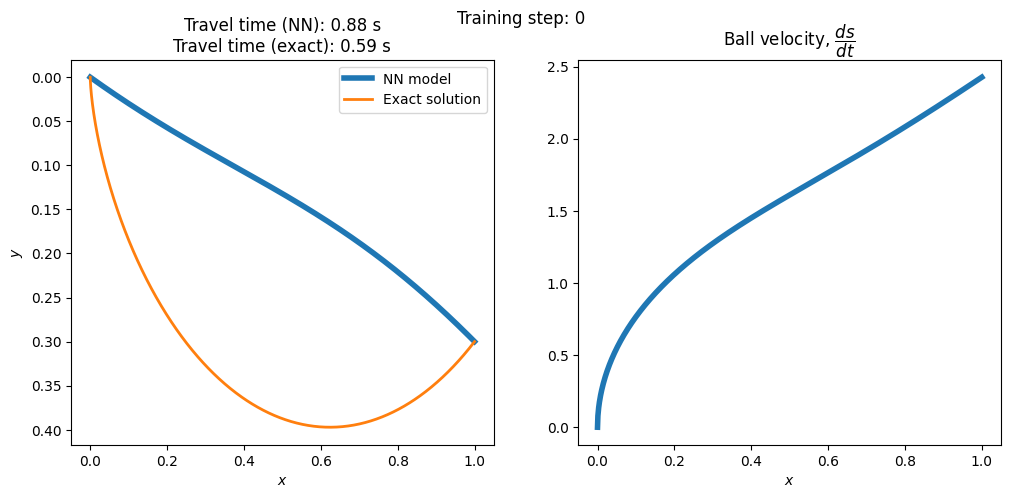

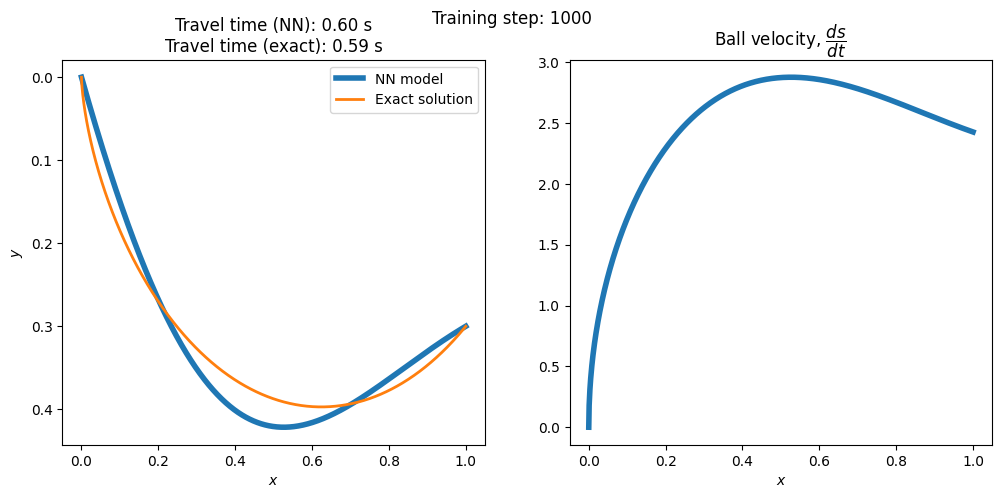

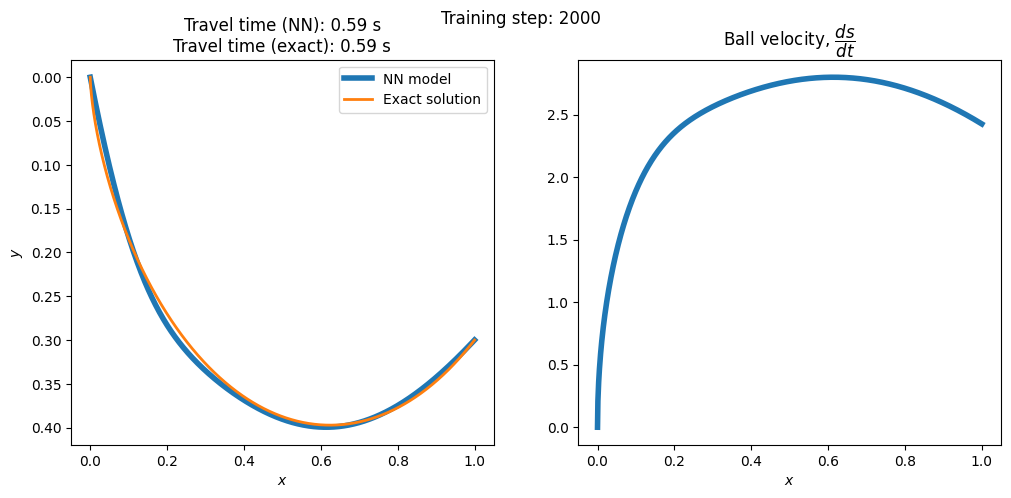

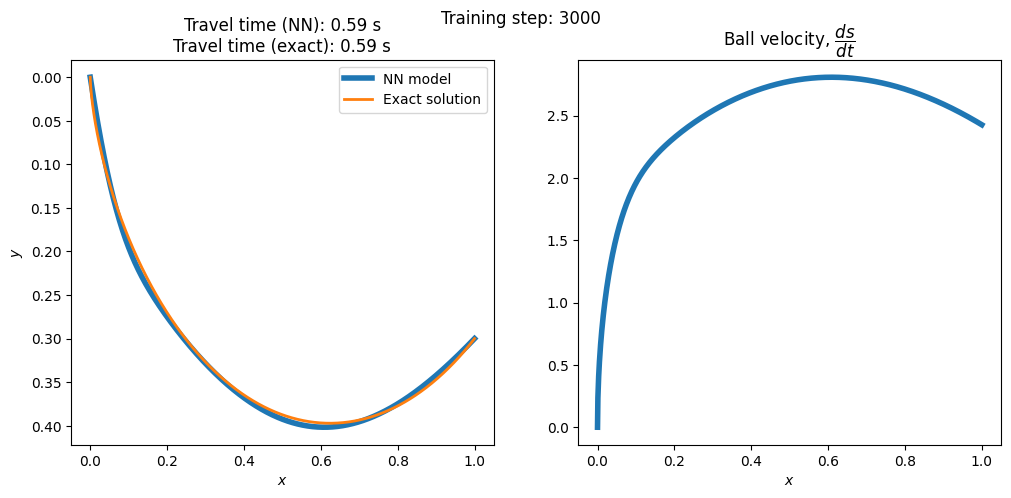

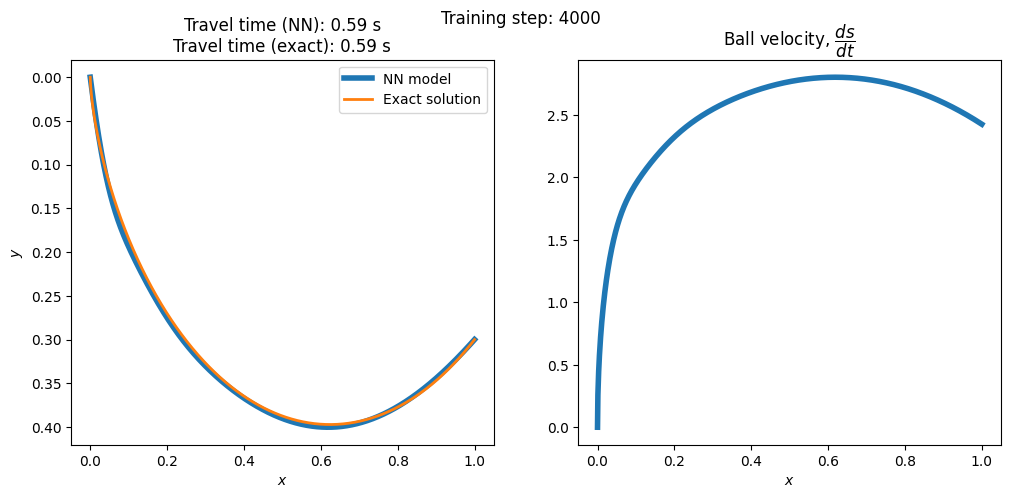

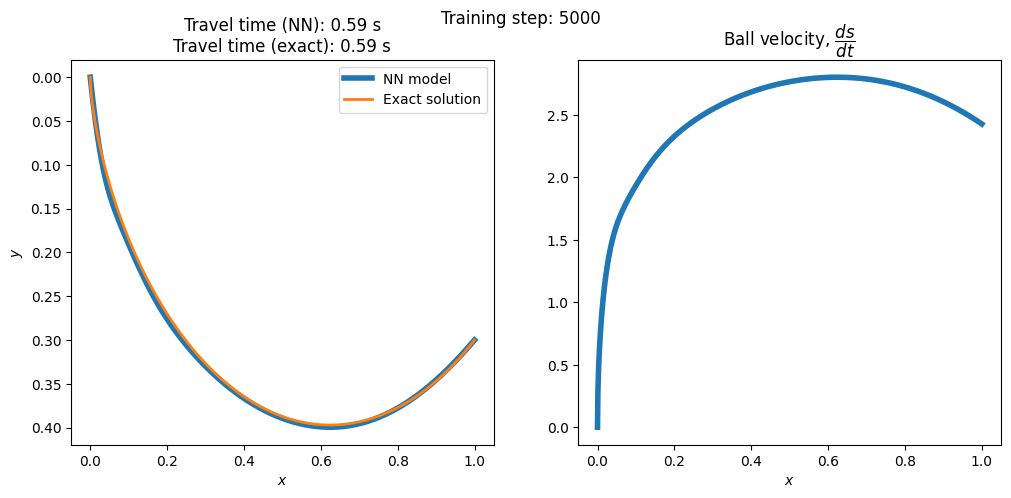

In [4]:
# define the problem
x2,y2 = 1,0.3
g = 9.81

# define our model
torch.manual_seed(0)
model = NN_Ansatz(1,1,8,2)

# define number of points / step size to integrate travel time over
n = 10000
dx = x2/n
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for it in range(5001):
    optimizer.zero_grad()

    # 1. compute the travel time of the model
    # by using numerical integration
    x = dx*torch.arange(1,n+1,dtype=torch.float32, requires_grad=True).reshape((-1,1))
    y = model(x, x2, y2)
    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    f = torch.sqrt((1+dy**2)/(2*g*y))
    t = torch.trapezoid(f, x, dim=0)# integrates f
    
    # 2. minimise the travel time to find the Brachistochrone curve
    t.backward()
    optimizer.step()
    
    
    
    # plot the results
    if it % 1000 == 0:
        
        x = torch.linspace(0,1,1000, requires_grad=True).reshape((-1,1))
        y = model(x, x2, y2)
        
        # get exact solution
        theta2, R = cycloid(x2, y2)
        theta = np.linspace(0, theta2, 1000)
        x_true = R * (theta - np.sin(theta))
        y_true = R * (1 - np.cos(theta))
        t_true = theta2 * np.sqrt(R / g)

        plt.figure(figsize=(12,5))
        plt.suptitle(f"Training step: {it}")
        plt.subplot(1,2,1)
        plt.title(f"Travel time (NN): {t.item():.2f} s\nTravel time (exact): {t_true:.2f} s")    
        plt.plot(x.detach()[:,0], y.detach()[:,0], linewidth=4, label="NN model")
        plt.plot(x_true, y_true, linewidth=2, label="Exact solution")
        ylim = plt.ylim()
        plt.ylim(ylim[1], ylim[0])
        plt.xlabel("$x$"); plt.ylabel("$y$")
        plt.legend()
        plt.subplot(1,2,2)
        plt.title("Ball velocity, $\dfrac{ds}{dt}$")
        plt.plot(x.detach()[:,0], torch.sqrt(2*g*y).detach()[:,0], linewidth=4)
        plt.xlabel("$x$")
        plt.show()